### Simple model without horizon and location
$y_t \mid \varepsilon_t = \theta + \sum_{p=1} \phi_p y_{t-p} + \varepsilon_t, \\
\varepsilon_t \sim N(0, \sigma_{\eta}) $


In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['MPLBACKEND'] = 'TKAgg'

import numpy as np
import pandas as pd
# matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import date

import jax
import jax.numpy as jnp

import arviz as az


In [2]:
from arh_simpler import ARHDFA

/home/eray/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def loaddata(model1, model2, val, mean_axis):
    mypath = f'../Data/death_diff_scores/{model1}_{model2}.csv'
    df = pd.read_csv(mypath)
    lix = pd.MultiIndex.from_product([np.unique(df.location), np.unique(df.relative_horizon)])
    df_pivot = (df.pivot_table(val, 'reference_date', ['location', 'relative_horizon'], aggfunc='first')).reindex(lix, axis=1)
    mydf = jnp.array(df_pivot.groupby(level=0, axis=1).agg(lambda x: [*x.values]).to_numpy().tolist())
    if model1 == 'COVIDhub-baseline' or model2 == 'COVIDhub-baseline':
        indices_to_change = [(38, 13), (21, 24), (24, 41)]
        for index in indices_to_change:
            mydf = mydf.at[index[0], index[1], :].set(np.nan) 
        print(mydf[38,13,:])
    if mean_axis == 'location':
        mydf_mean = np.mean(mydf, axis=1)
        mydf_reshape = mydf_mean.reshape(mydf_mean.shape[0],1,mydf_mean.shape[1])
    elif mean_axis == 'horizon':
        mydf_mean = np.mean(mydf, axis=2)
        mydf_reshape = mydf_mean.reshape(mydf_mean.shape[0],mydf_mean.shape[1],1)
    elif mean_axis == 'both':
        mydf_mean = np.mean(mydf, axis=(1,2))
        mydf_reshape = mydf_mean.reshape(mydf_mean.shape[0],1,1)
    else:  mydf_reshape = mydf[:,0,0].reshape(mydf.shape[0],1,1)
    return mydf_reshape

In [4]:
def dfa_ftn(model1, model2, val, mean_axis, p=1, q=1,
            sigma_time = 'constant', ar_constraint='[0,1]',
            num_chains=3,
            num_warmup=5000,
            num_samples=5000):
    obs = loaddata(model1, model2, val, mean_axis)
    # Define a DFA model with specified parameter values to use for data generation
    dfa_model = ARHDFA(num_timesteps=obs.shape[0], num_series=obs.shape[1], num_horizons=obs.shape[2], 
                        p=p, q=q, ar_constraint=ar_constraint, sigma_time=sigma_time,
                        ar_var_constraint='[0,1]')
    mcmc_samples = dfa_model.fit(y=obs,
                             rng_key=jax.random.PRNGKey(79942),
                             num_warmup=num_warmup,
                             num_samples=num_samples,
                             thinning = 1,
                             num_chains=num_chains)
    dfa_model.mcmc.print_summary()
    waic = az.waic(az.from_numpyro(mcmc_samples))
    print(waic)
    az.plot_pair(az.from_numpyro(mcmc_samples), 
             divergences=True,
             colorbar=True)
    az.plot_trace(az.from_numpyro(mcmc_samples))

    return dfa_model, mcmc_samples




/tmp/ipykernel_22894/1880337169.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mydf = jnp.array(df_pivot.groupby(level=0, axis=1).agg(lambda x: [*x.values]).to_numpy().tolist())
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/eray/research/epi/methods/Comparing-Forecast-Performance/DFA/arh_simpler.py:307: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = numpyro.infer.MCMC(


[nan nan nan nan]


sample: 100%|██████████| 10000/10000 [00:05<00:00, 1736.71it/s, 31 steps of size 1.31e-01. acc. prob=0.93]



MCMC elapsed time: 25.167136907577515

                          mean       std    median      5.0%     95.0%     n_eff     r_hat
       ARVar_mu[0,0]      1.16      1.03      1.15     -0.54      2.86  14248.97      1.00
        intercept[0]    -20.37      4.42    -20.45    -27.04    -13.03   1245.27      1.00
    log_sigma_eps[0]      1.00      1.00      1.00     -0.66      2.63  24790.21      1.00
log_sigma_eta_0[0,0]      1.00      1.00      1.00     -0.72      2.57  24536.46      1.00
log_sigma_eta_t[0,0]      4.40      0.13      4.39      4.18      4.62  11476.47      1.00
          m_t[0,0,0]      0.09      4.50      0.14     -6.94      7.35   1289.30      1.00
          m_t[1,0,0]      8.01      7.37      8.06     -4.42     19.45   3167.26      1.00
          m_t[2,0,0]      6.79      7.52      6.78     -5.78     18.79   3254.96      1.00
          m_t[3,0,0]      2.73      7.55      2.74     -9.73     14.87   3352.45      1.00
          m_t[4,0,0]     -2.69      7.49     -2.65

/home/eray/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 15000 posterior samples and 117 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -435.68     6.71
p_waic        9.99        -

There has been a warning during the calculation. Please check the results.


/home/eray/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


(<arh_simpler.ARHDFA at 0x7f929af35ba0>,
 <numpyro.infer.mcmc.MCMC at 0x7f932accf0d0>)

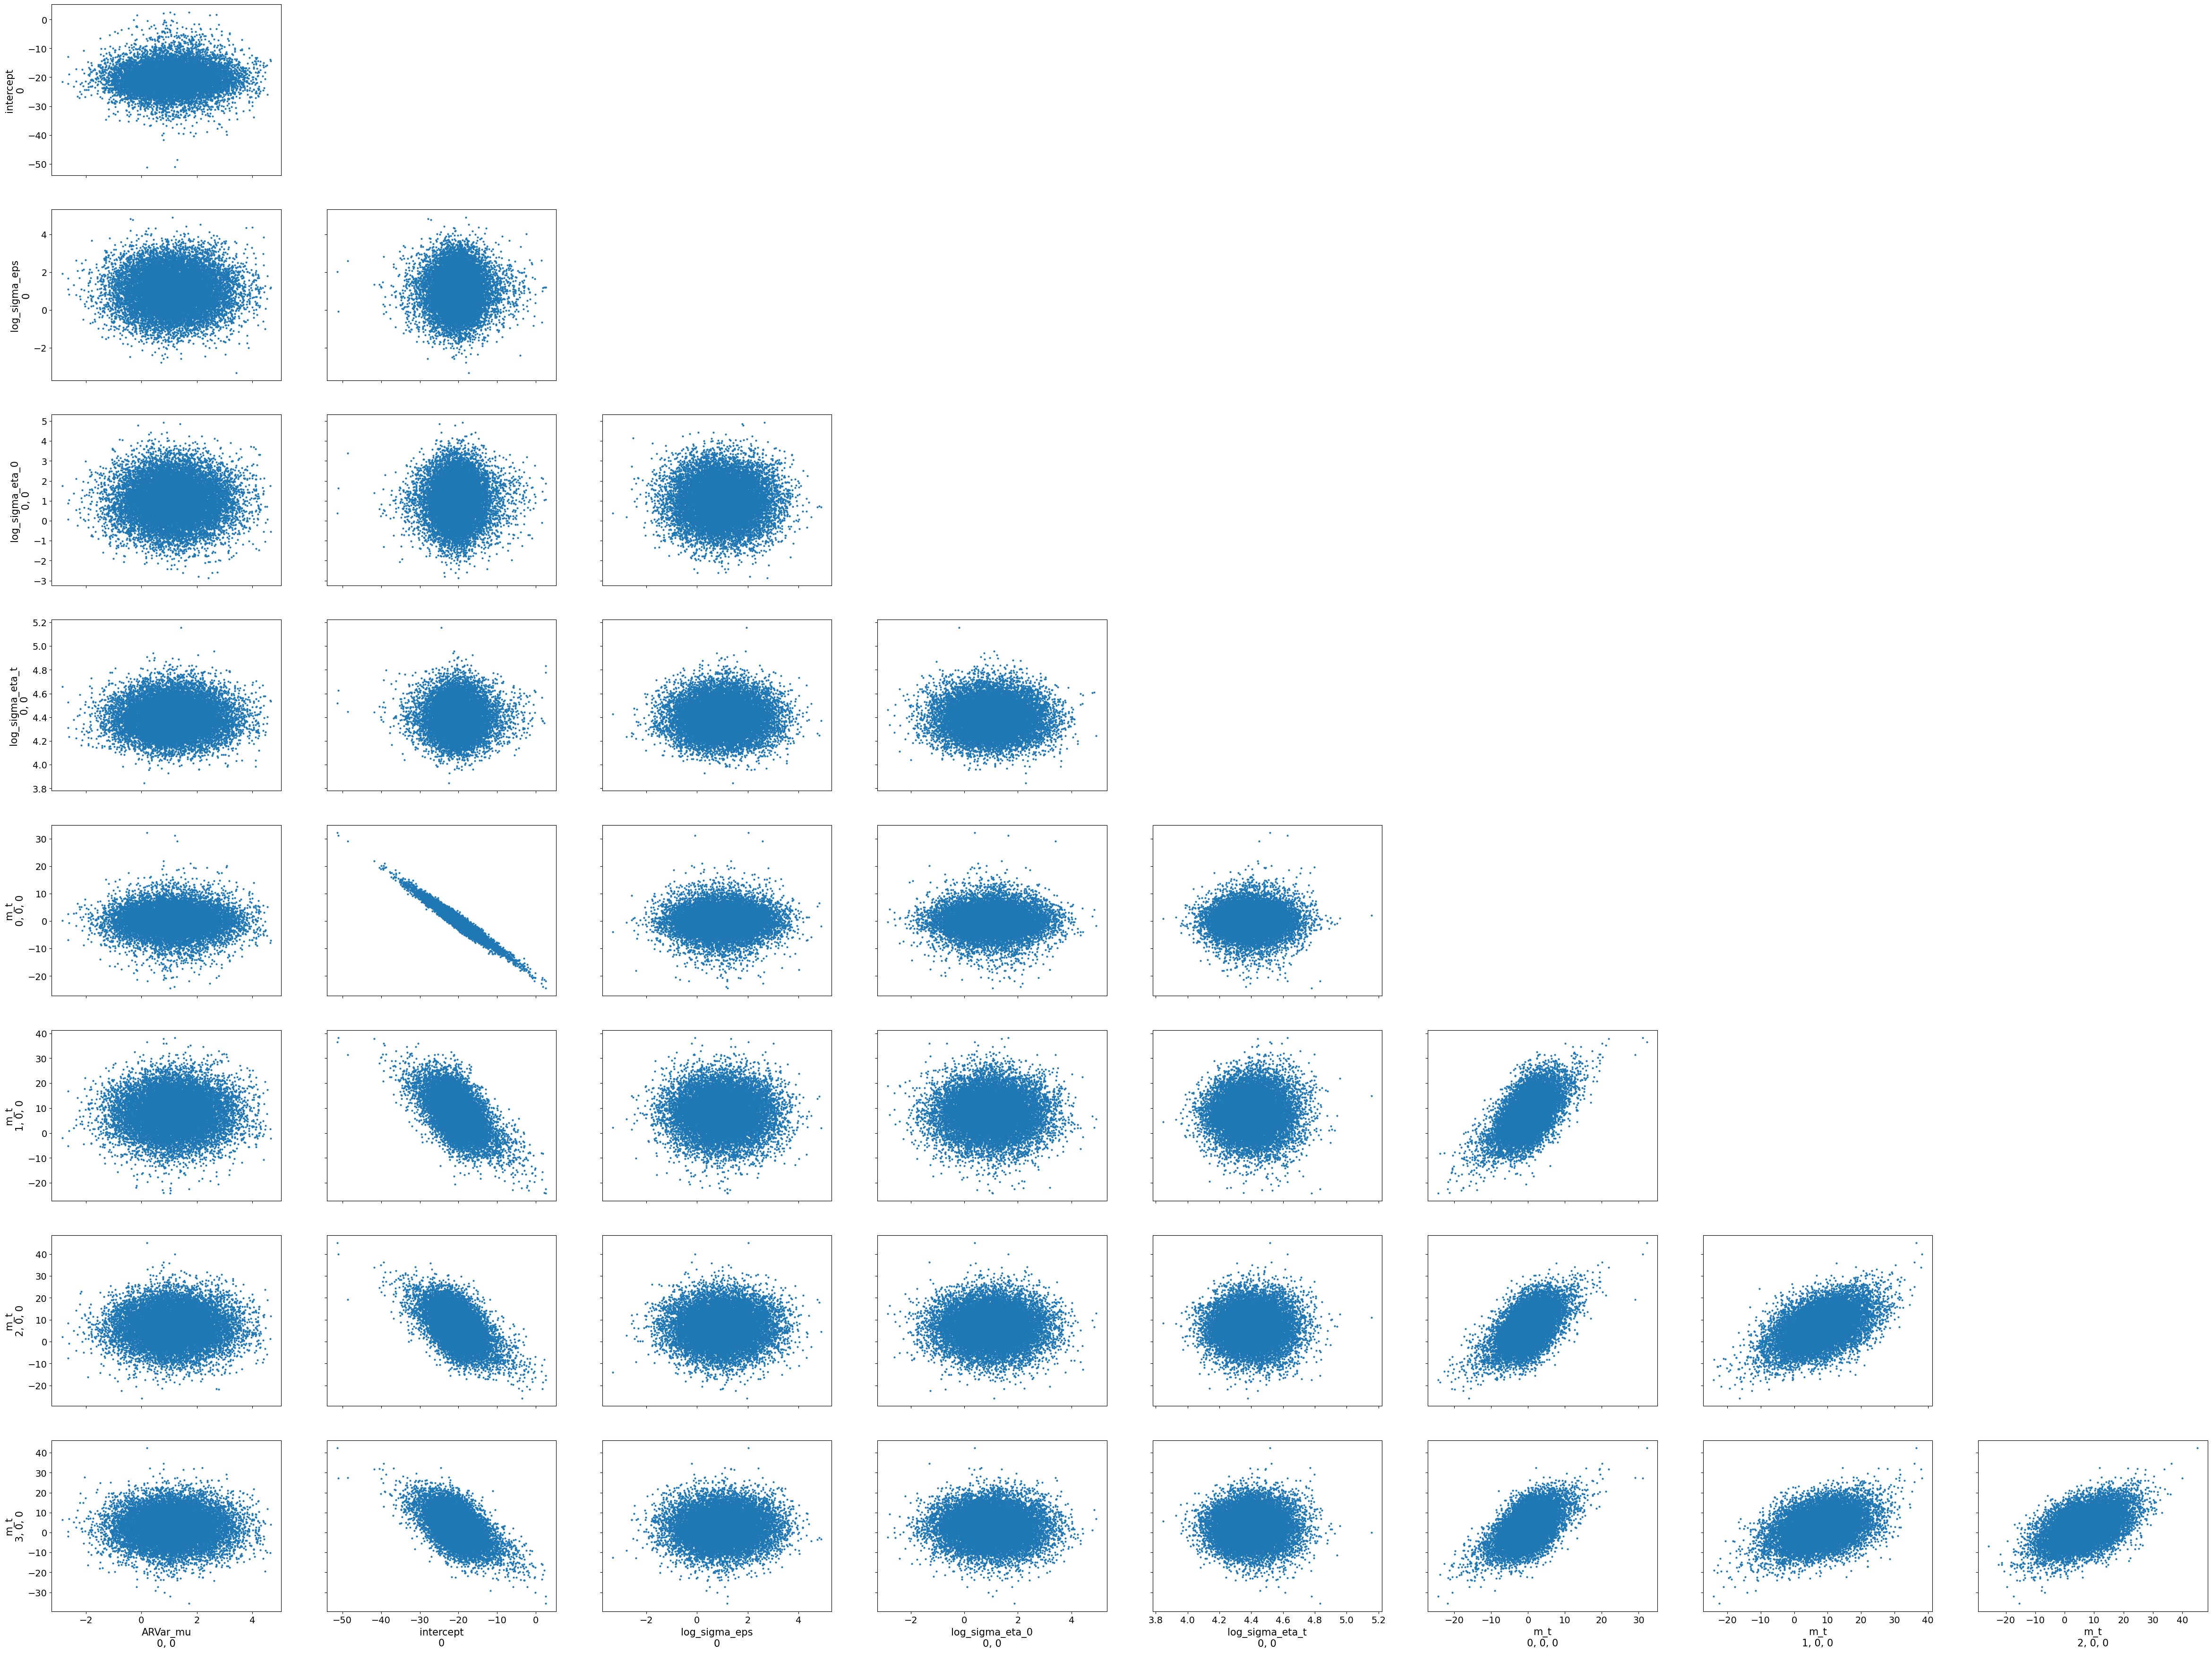

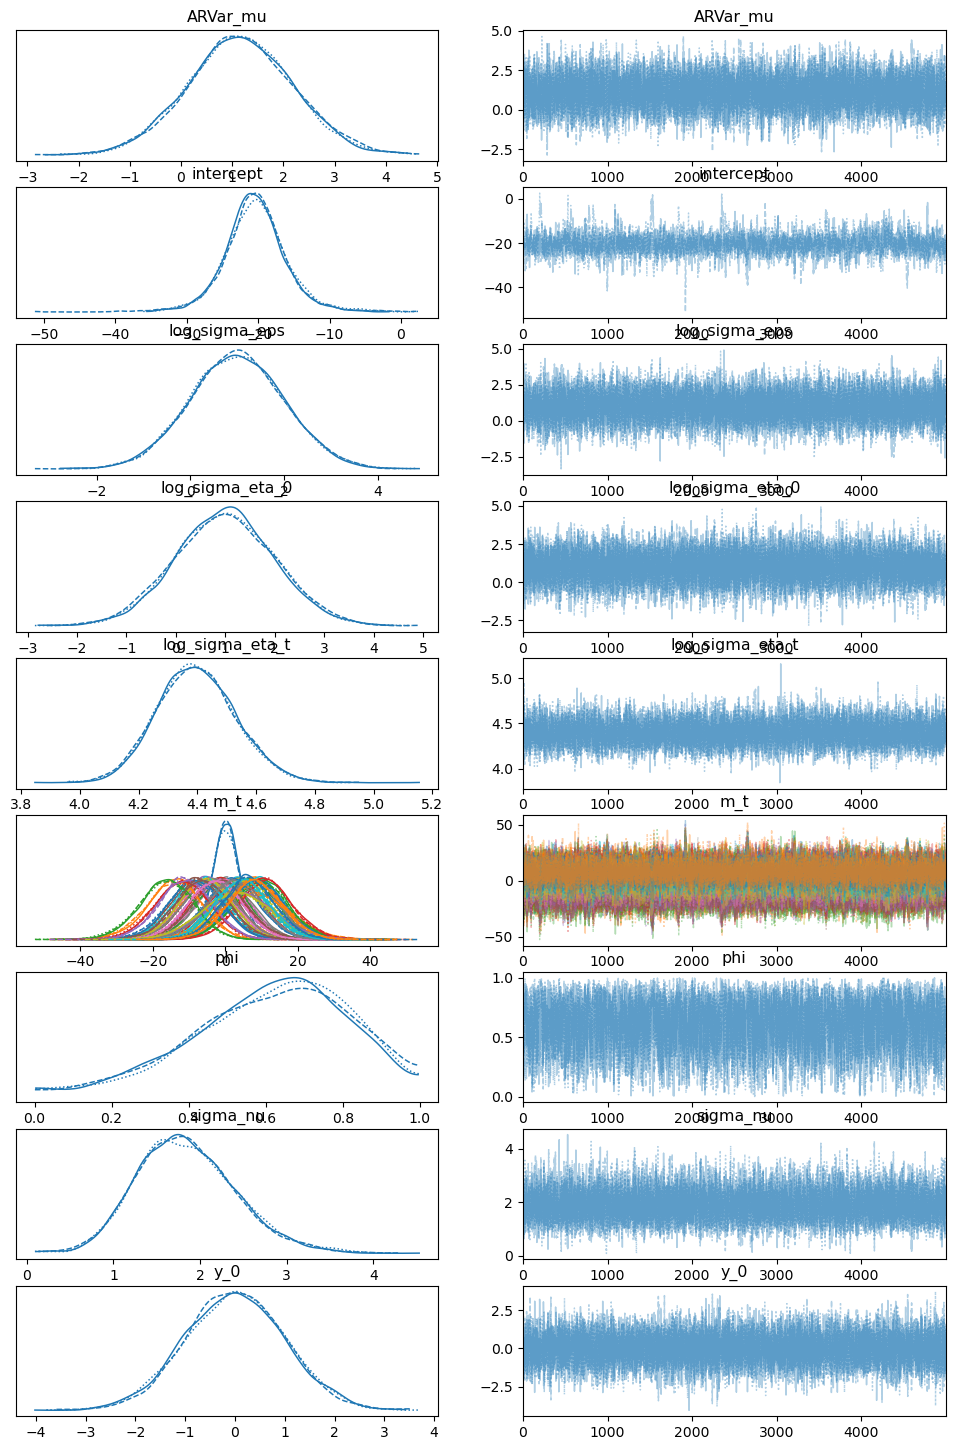

In [5]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=1, q=1, sigma_time = 'constant')

/tmp/ipykernel_22894/1880337169.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mydf = jnp.array(df_pivot.groupby(level=0, axis=1).agg(lambda x: [*x.values]).to_numpy().tolist())
/home/eray/research/epi/methods/Comparing-Forecast-Performance/DFA/arh_simpler.py:307: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = numpyro.infer.MCMC(


[nan nan nan nan]


sample: 100%|██████████| 10000/10000 [00:05<00:00, 1750.51it/s, 31 steps of size 1.05e-01. acc. prob=0.95]



MCMC elapsed time: 22.98859167098999

                          mean       std    median      5.0%     95.0%     n_eff     r_hat
       ARVar_mu[0,0]      1.17      1.03      1.16     -0.53      2.83  10821.69      1.00
        intercept[0]    -19.43      5.40    -19.62    -28.81    -11.11    694.97      1.00
    log_sigma_eps[0]      0.99      1.02      1.00     -0.68      2.64  17921.82      1.00
log_sigma_eta_0[0,0]      1.00      1.00      0.99     -0.64      2.67  18305.46      1.00
log_sigma_eta_t[0,0]      4.40      0.13      4.40      4.19      4.62  10922.16      1.00
          m_t[0,0,0]     -0.84      5.44     -0.65     -9.36      8.51    717.05      1.00
          m_t[1,0,0]      6.87      7.61      6.83     -5.36     19.51   1696.83      1.00
          m_t[2,0,0]      4.79      8.12      4.91     -8.28     18.32   1501.56      1.00
          m_t[3,0,0]      1.78      8.04      1.84    -11.72     14.61   1562.18      1.00
          m_t[4,0,0]     -2.72      8.10     -2.60 

/home/eray/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 15000 posterior samples and 117 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -435.97     6.68
p_waic       10.09        -

There has been a warning during the calculation. Please check the results.


/home/eray/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


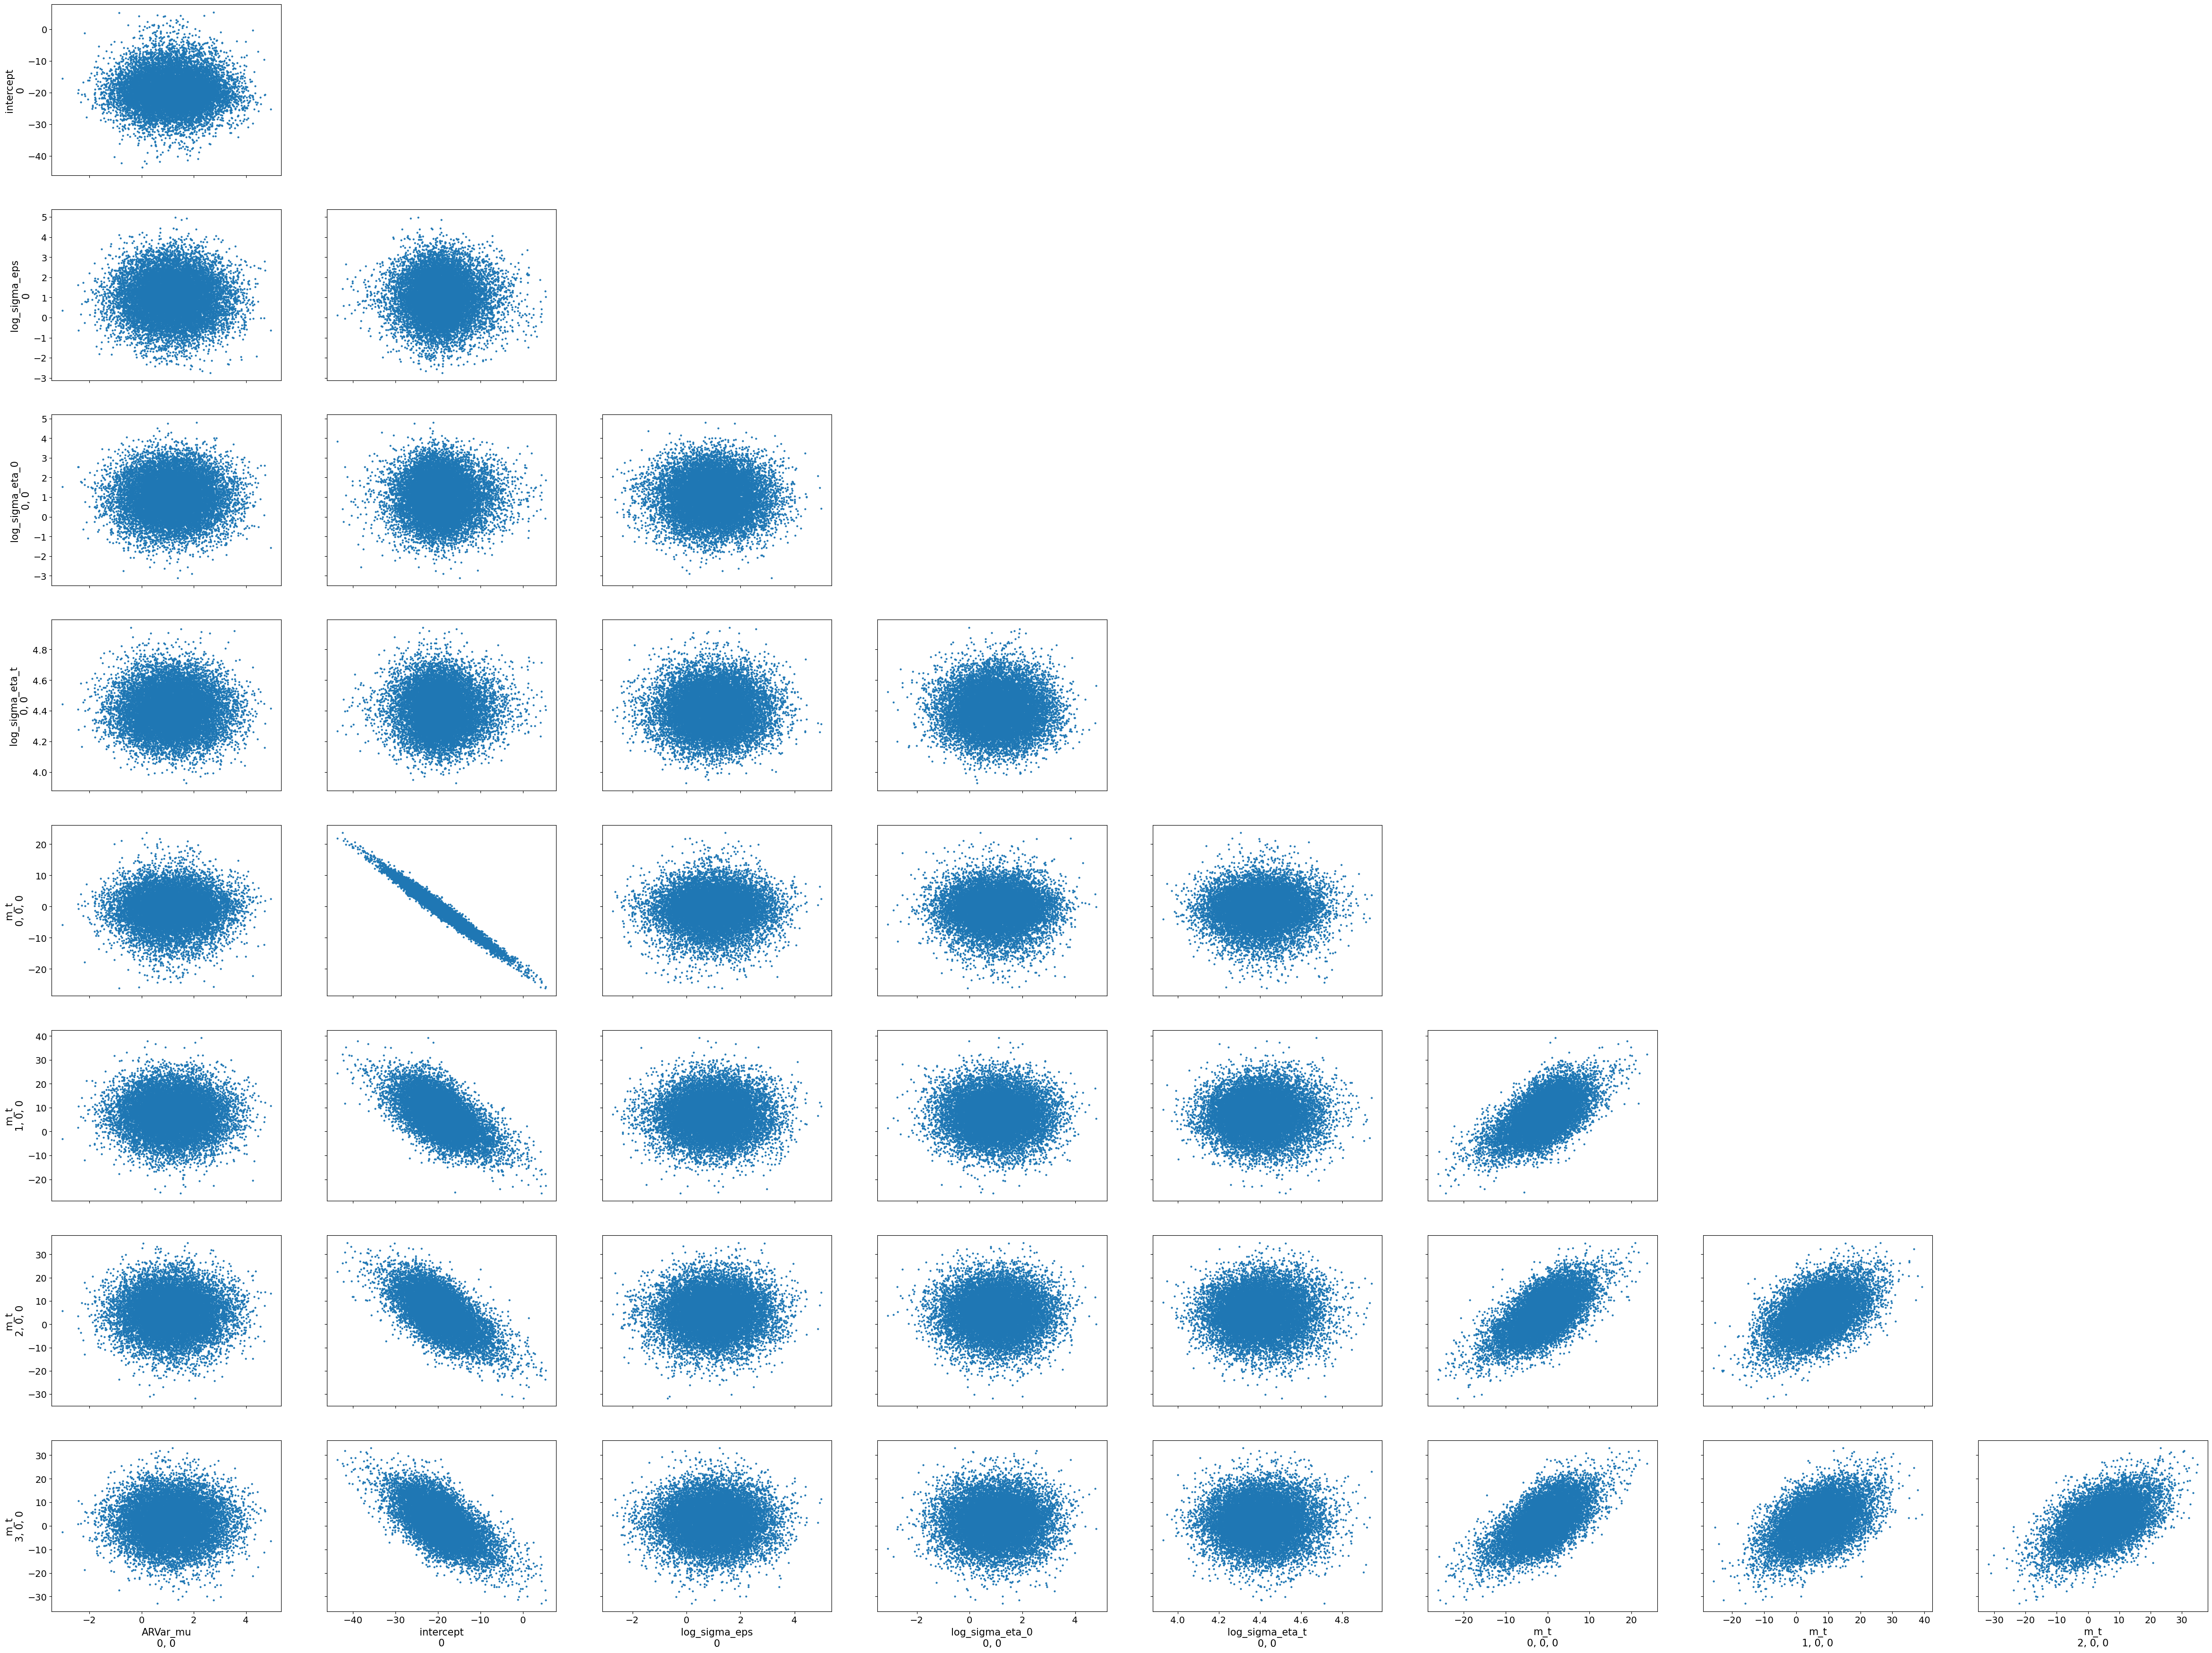

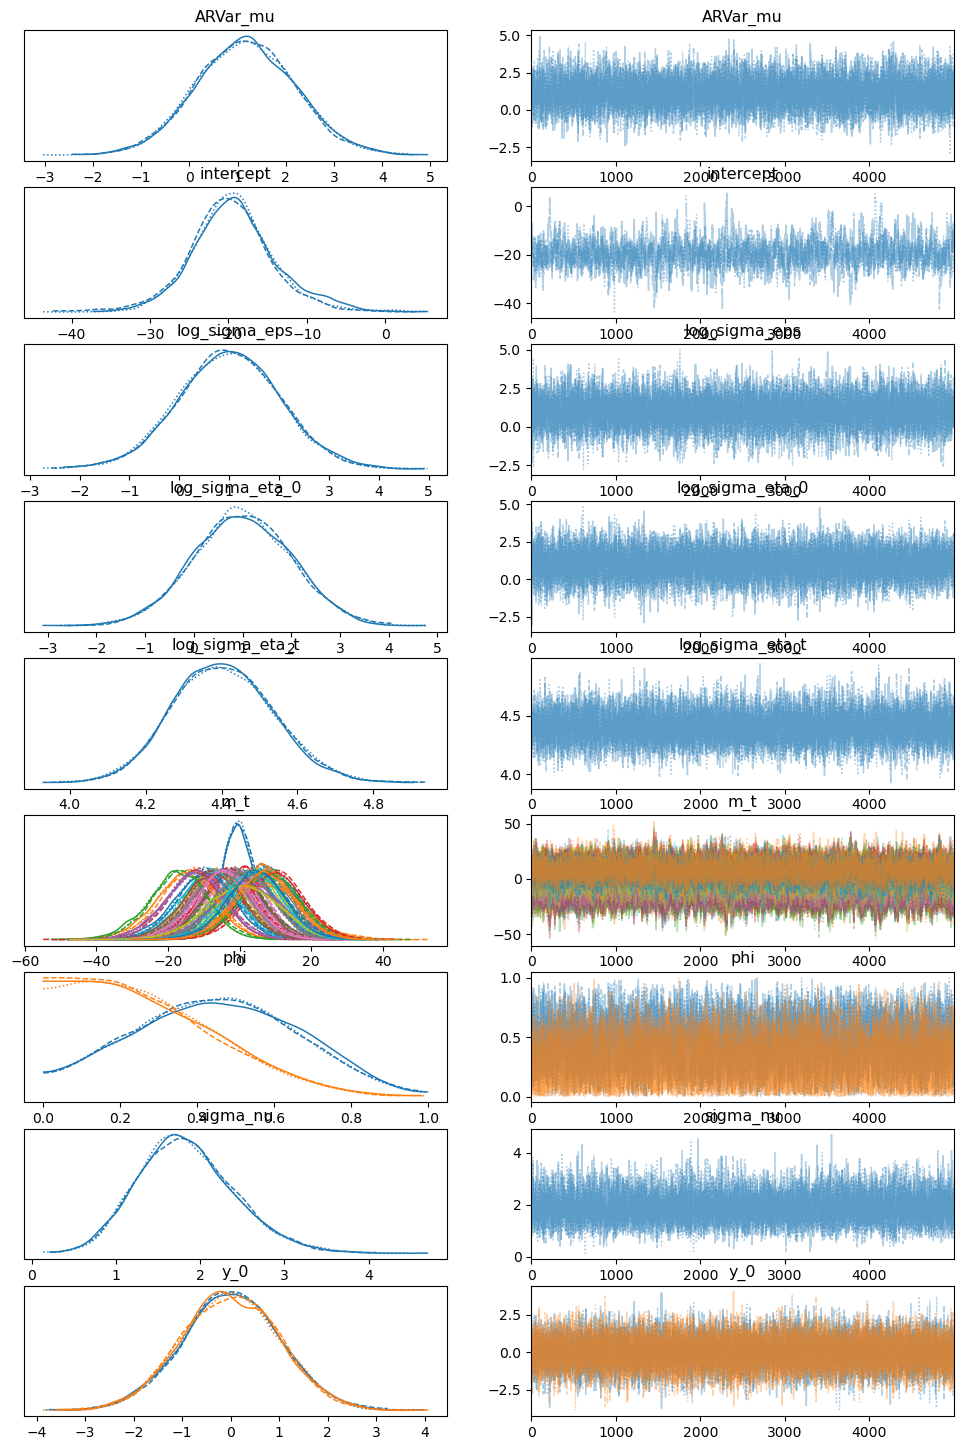

In [6]:
dfa_model, mcmc_samples = dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both',
                                  p=2, q=1, sigma_time = 'constant',
                                  num_warmup=5000, num_samples=5000, num_chains=3)

In [7]:
samples = mcmc_samples.get_samples(group_by_chain=True)
samples.keys()

dict_keys(['ARVar_mu', 'intercept', 'log_sigma_eps', 'log_sigma_eta_0', 'log_sigma_eta_t', 'm_t', 'phi', 'sigma_nu', 'y_0'])

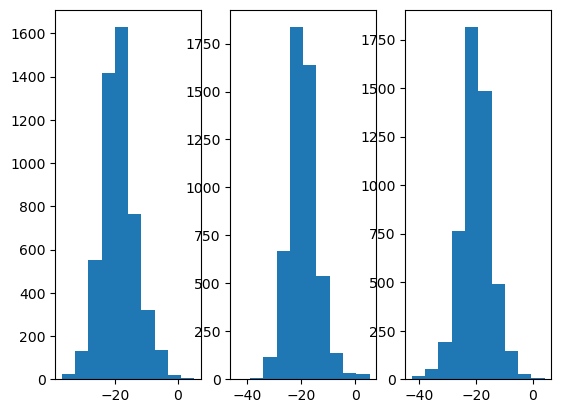

In [8]:
samples['intercept'].shape
fig, ax = plt.subplots(1, 3)
for i in range(3):
  ax[i].hist(samples['intercept'][i, :, 0])


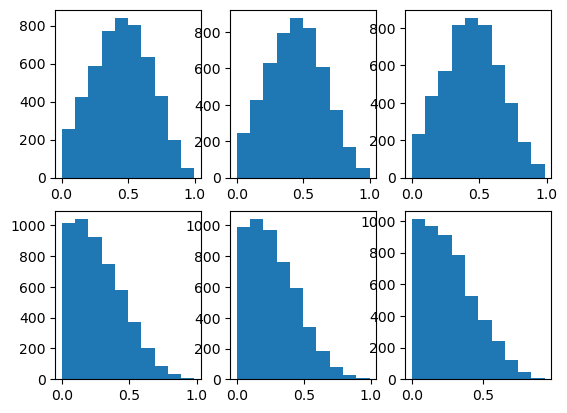

In [9]:
samples['phi'].shape
fig, ax = plt.subplots(2, 3)
for i in range(2):
  for j in range(3):
    ax[i, j].hist(samples['phi'][j, :, 0, i])

/home/eray/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='intercept\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log_sigma_eps\n0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log_sigma_eta_0\n0, 0'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log_sigma_eta_t\n0, 0'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='m_t\n0, 0, 0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='m_t\n1, 0, 0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='m_t\n2, 0, 0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='ARVar_mu\n0, 0', ylabel='m_t\n3, 0, 0'>,
        <Axes: xlabel='intercept\n0'>, <Axes: xlabel='log_sigma_eps\n0'>,
        <Axes:

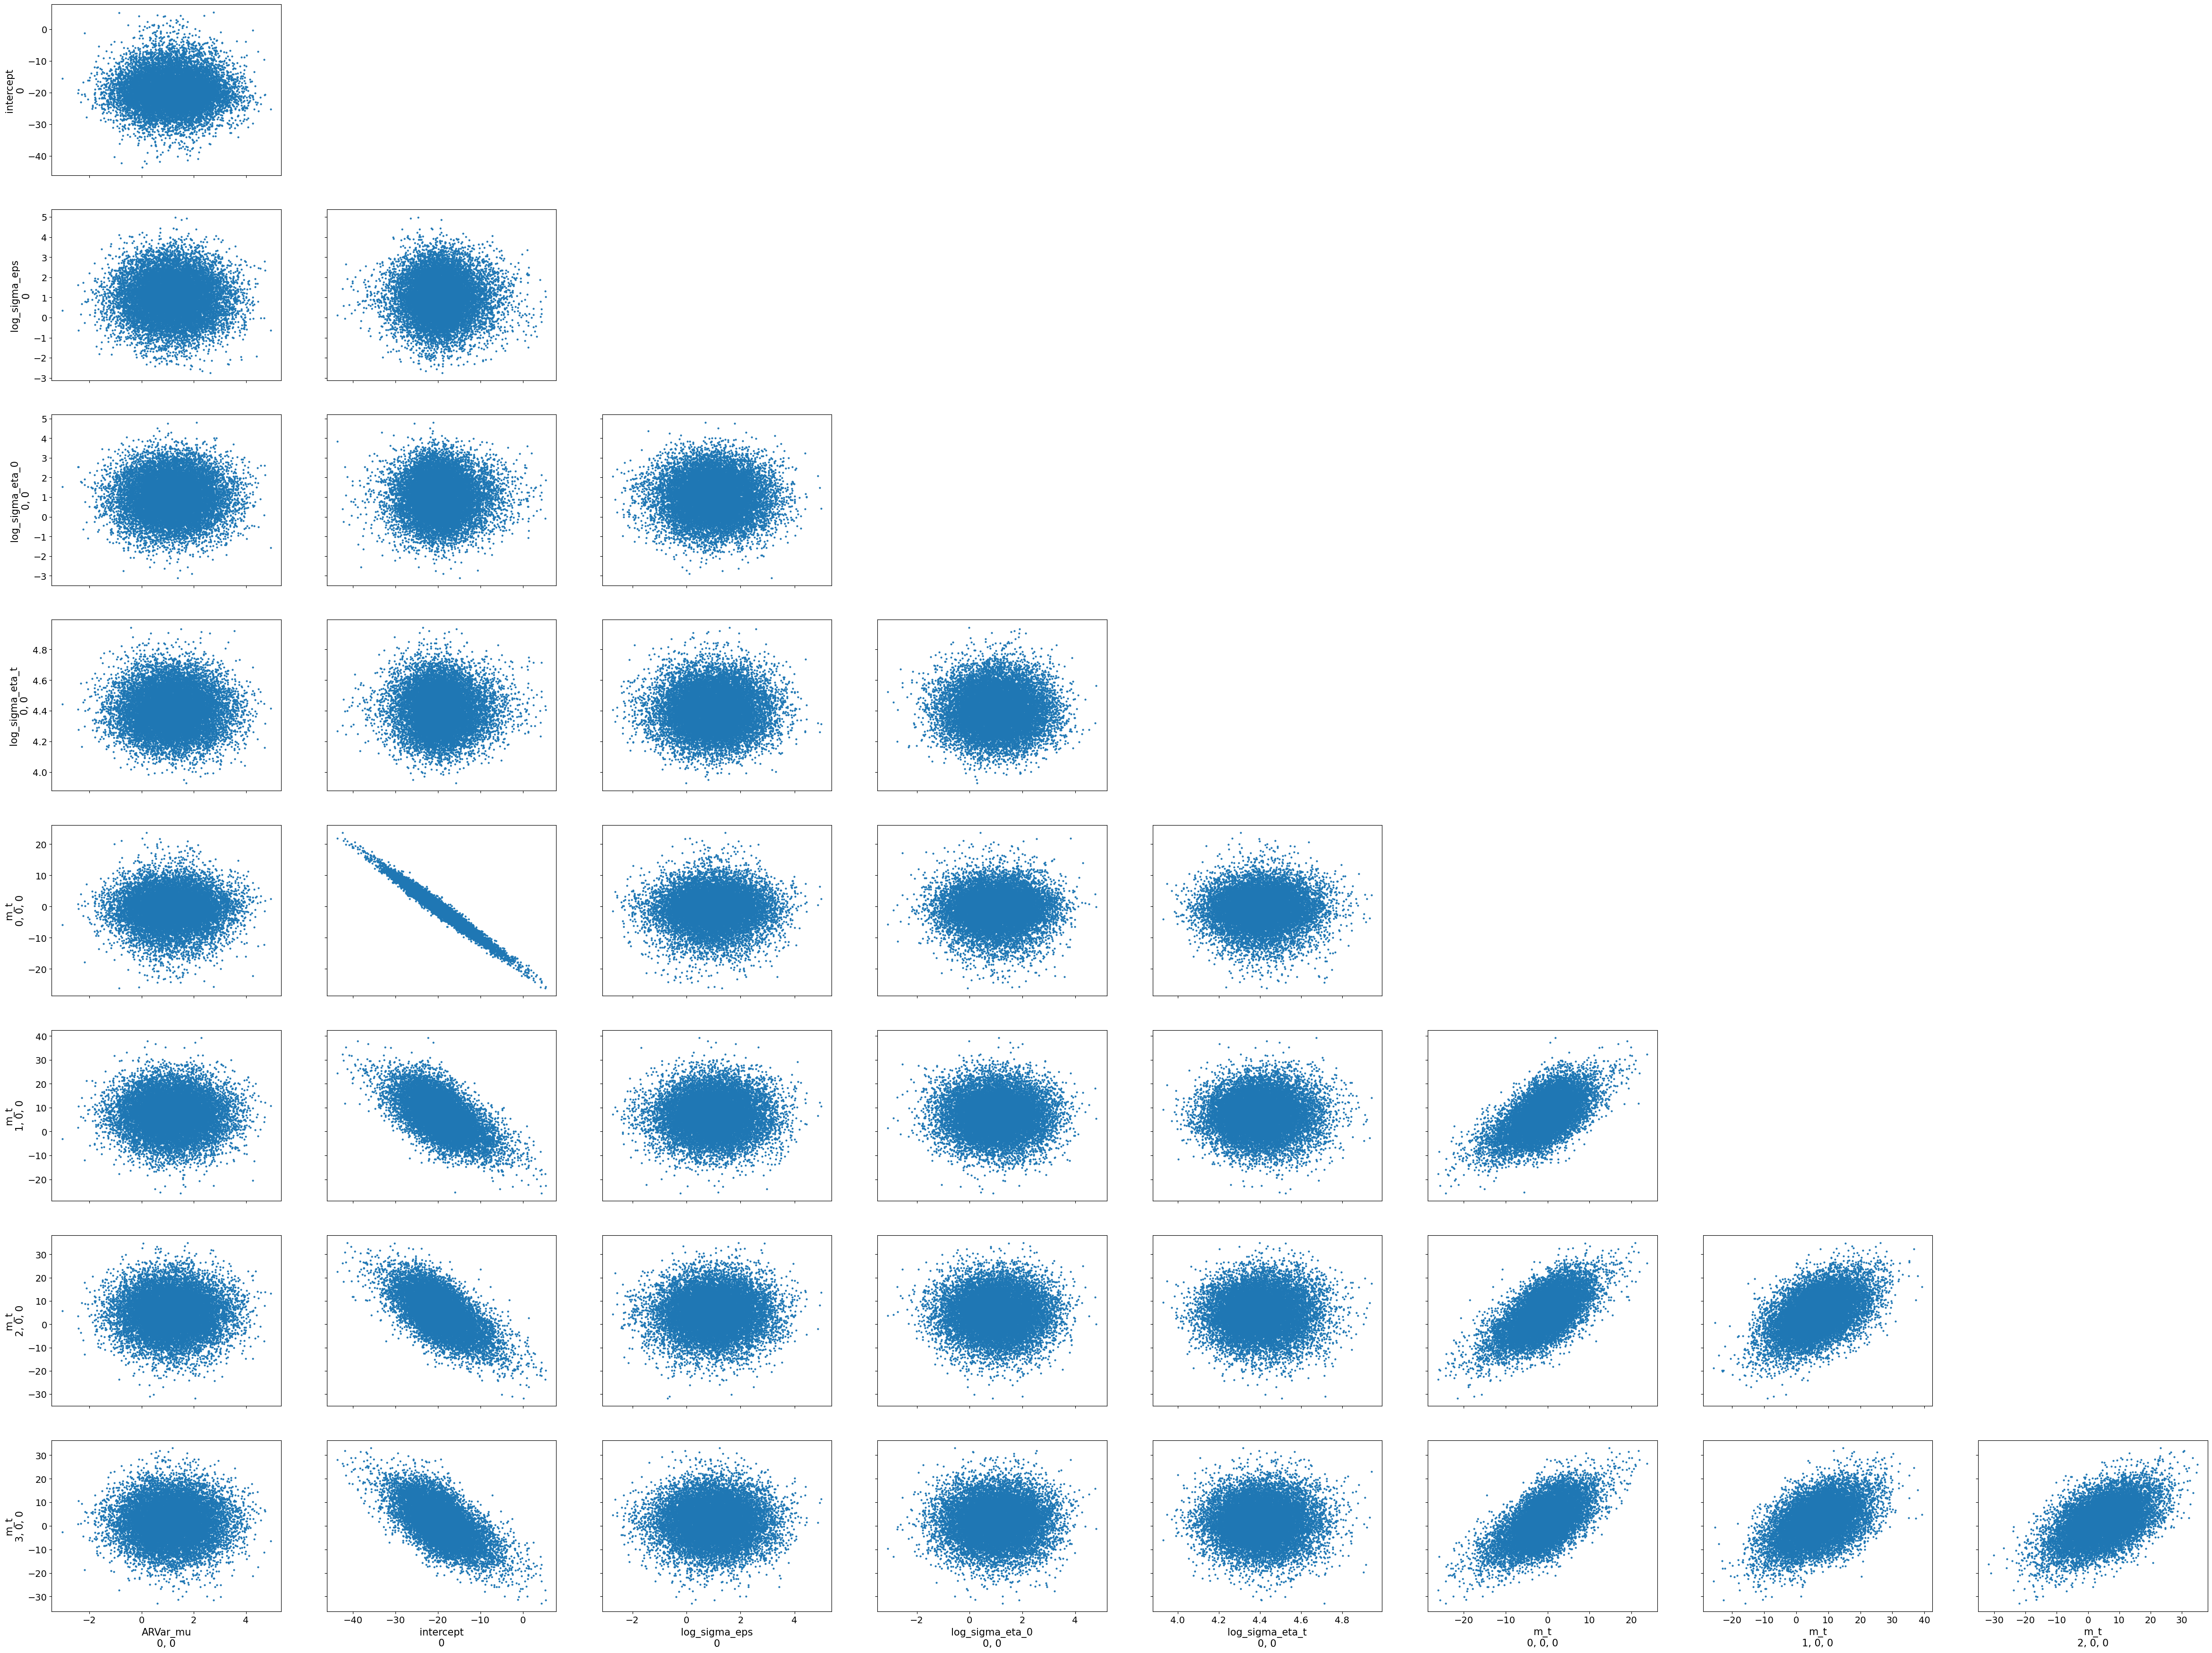

In [10]:
az.plot_pair(az.from_numpyro(mcmc_samples), 
             divergences=True,
             colorbar=True)


/tmp/ipykernel_22894/1880337169.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mydf = jnp.array(df_pivot.groupby(level=0, axis=1).agg(lambda x: [*x.values]).to_numpy().tolist())
/home/eray/research/epi/methods/Comparing-Forecast-Performance/DFA/arh_simpler.py:307: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = numpyro.infer.MCMC(


[nan nan nan nan]


sample: 100%|██████████| 10000/10000 [00:05<00:00, 1735.07it/s, 31 steps of size 1.12e-01. acc. prob=0.95]



MCMC elapsed time: 22.20146632194519

                          mean       std    median      5.0%     95.0%     n_eff     r_hat
       ARVar_mu[0,0]      1.16      1.02      1.15     -0.57      2.80  11606.91      1.00
        intercept[0]    -19.87      4.89    -20.03    -27.51    -11.67    784.20      1.00
    log_sigma_eps[0]      1.00      1.01      1.00     -0.68      2.65  18846.04      1.00
log_sigma_eta_0[0,0]      1.00      1.00      1.00     -0.63      2.64  18955.41      1.00
log_sigma_eta_t[0,0]      4.40      0.13      4.40      4.18      4.61  11202.15      1.00
          m_t[0,0,0]     -0.41      4.94     -0.23     -8.36      7.66    815.12      1.00
          m_t[1,0,0]      7.40      7.39      7.39     -5.03     19.38   2091.04      1.00
          m_t[2,0,0]      5.79      7.93      5.95     -7.47     18.42   1928.04      1.00
          m_t[3,0,0]      2.15      7.73      2.19    -10.68     14.62   1993.73      1.00
          m_t[4,0,0]     -2.76      7.83     -2.73 

/home/eray/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 15000 posterior samples and 117 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -436.12     6.68
p_waic       10.24        -

There has been a warning during the calculation. Please check the results.


/home/eray/miniconda3/envs/forecastskill/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


(<arh_simpler.ARHDFA at 0x7f91e43f6ef0>,
 <numpyro.infer.mcmc.MCMC at 0x7f92542b5d20>)

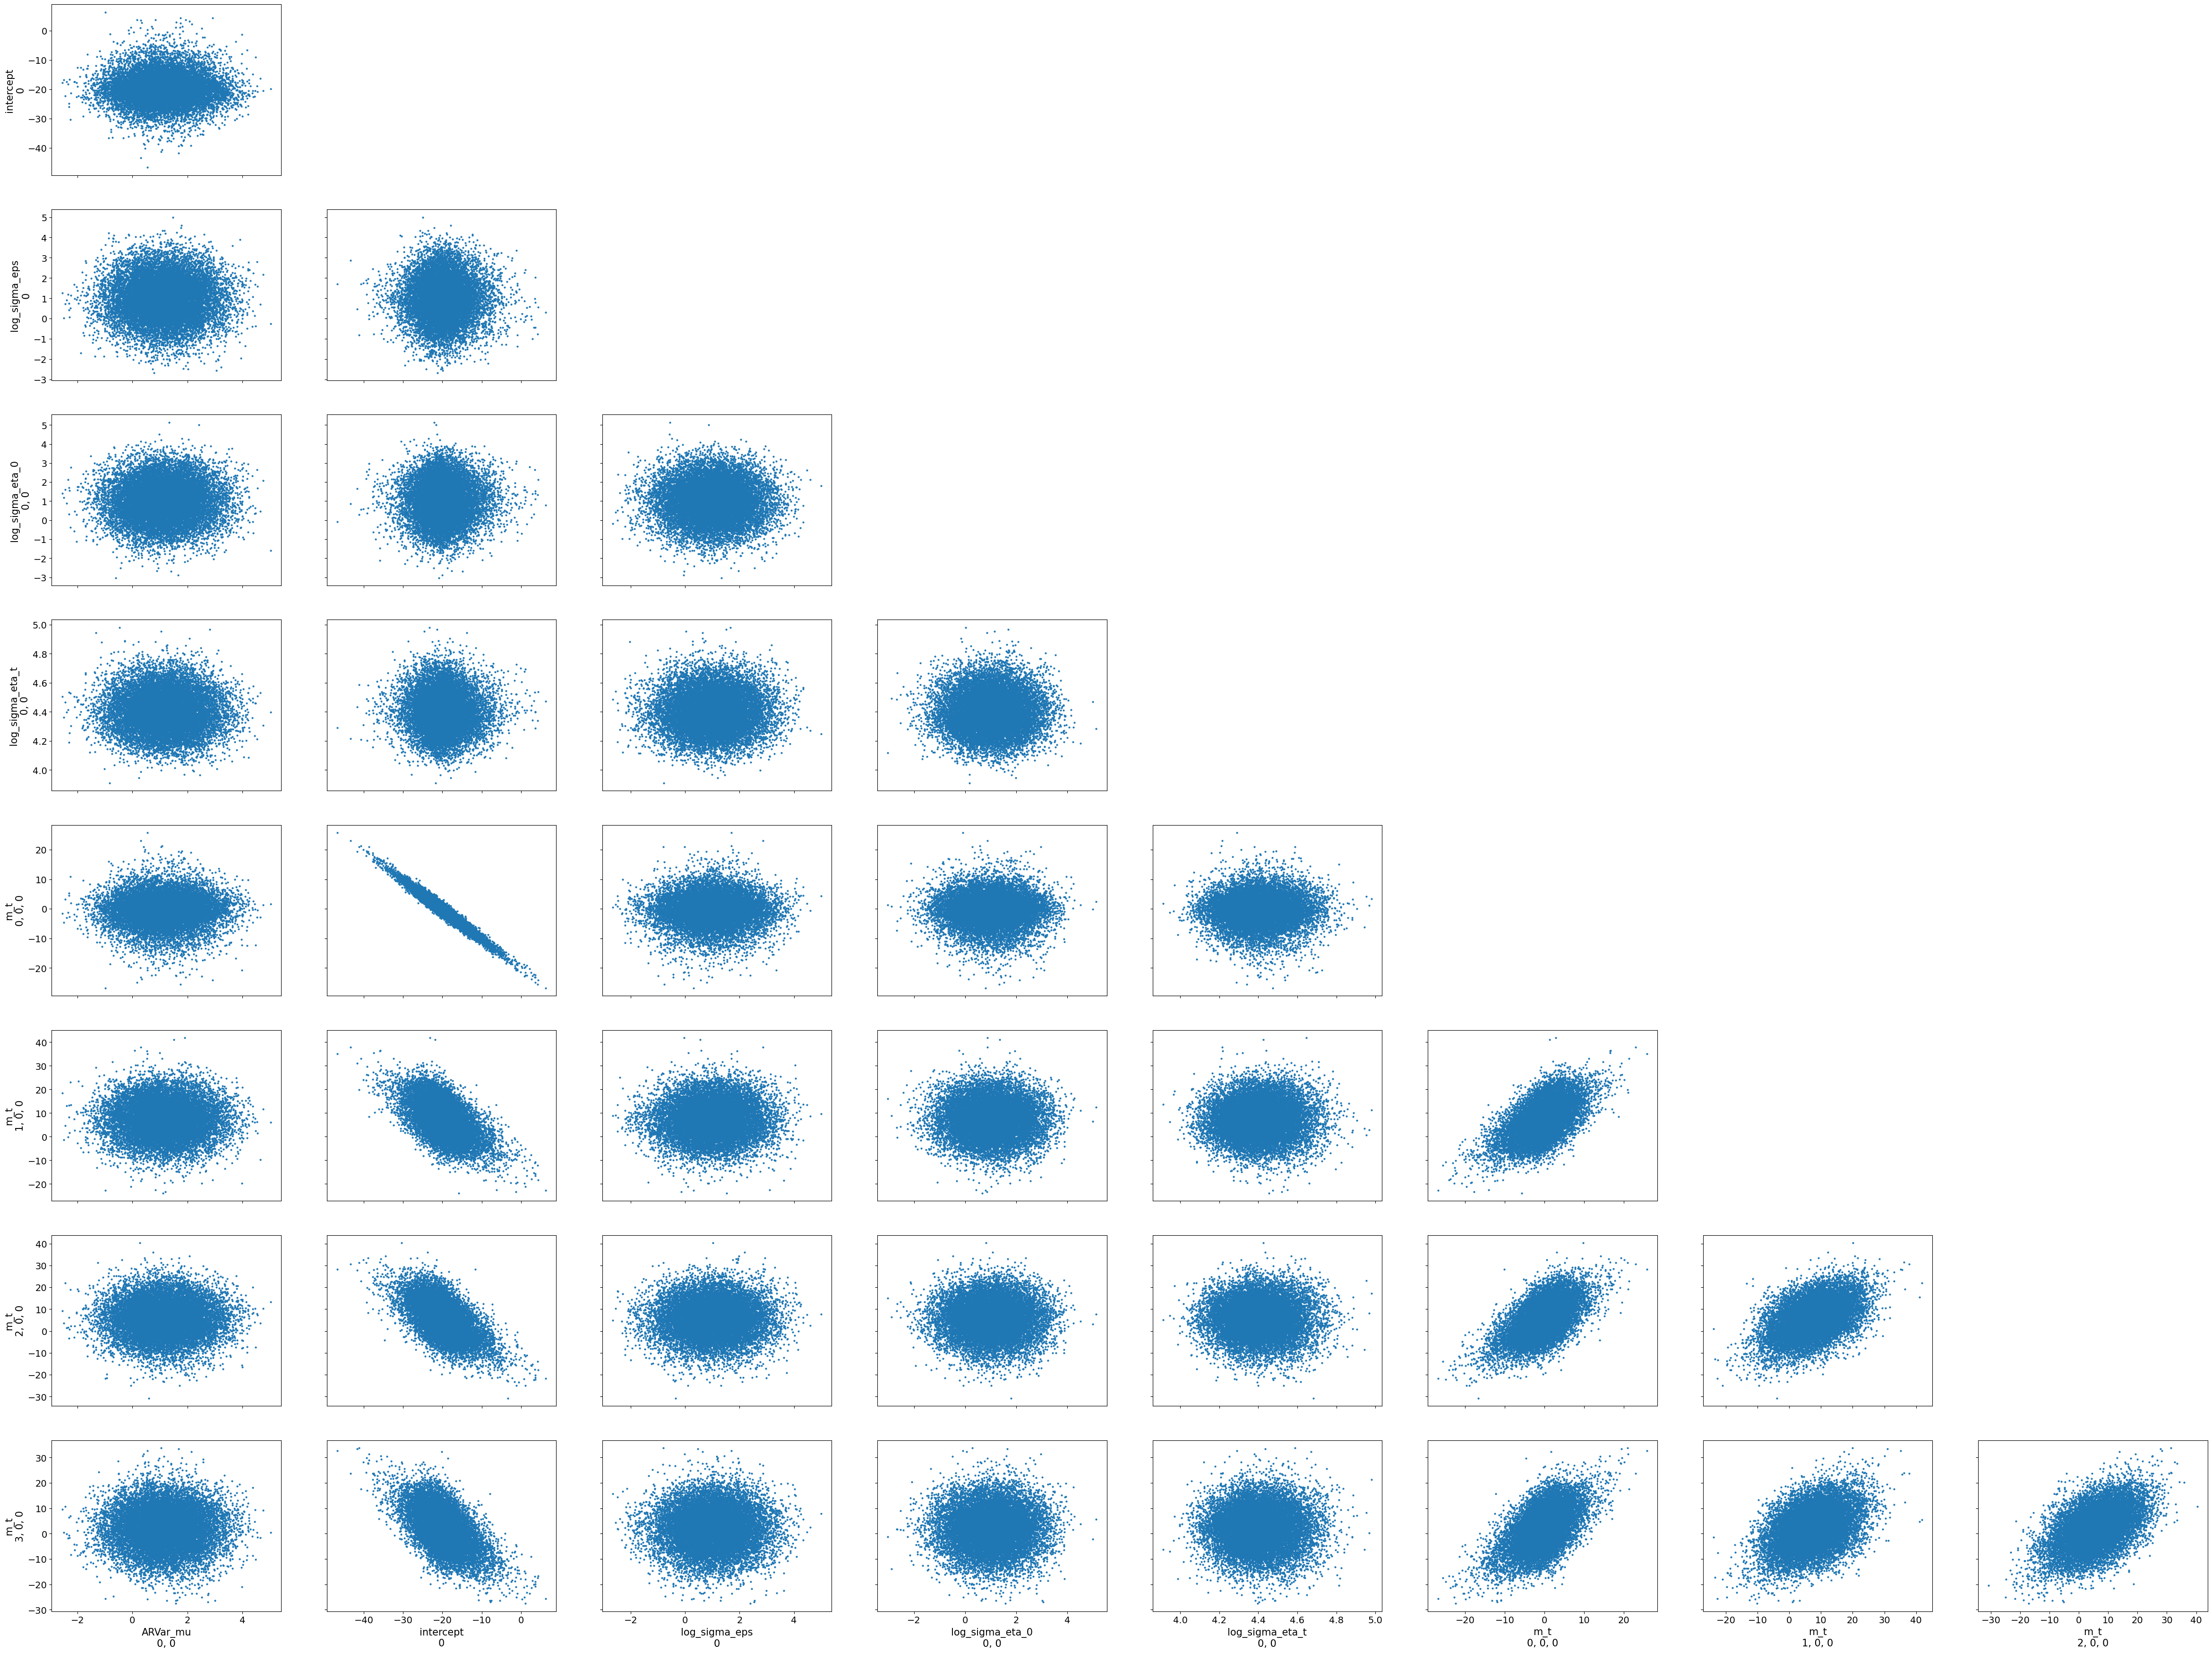

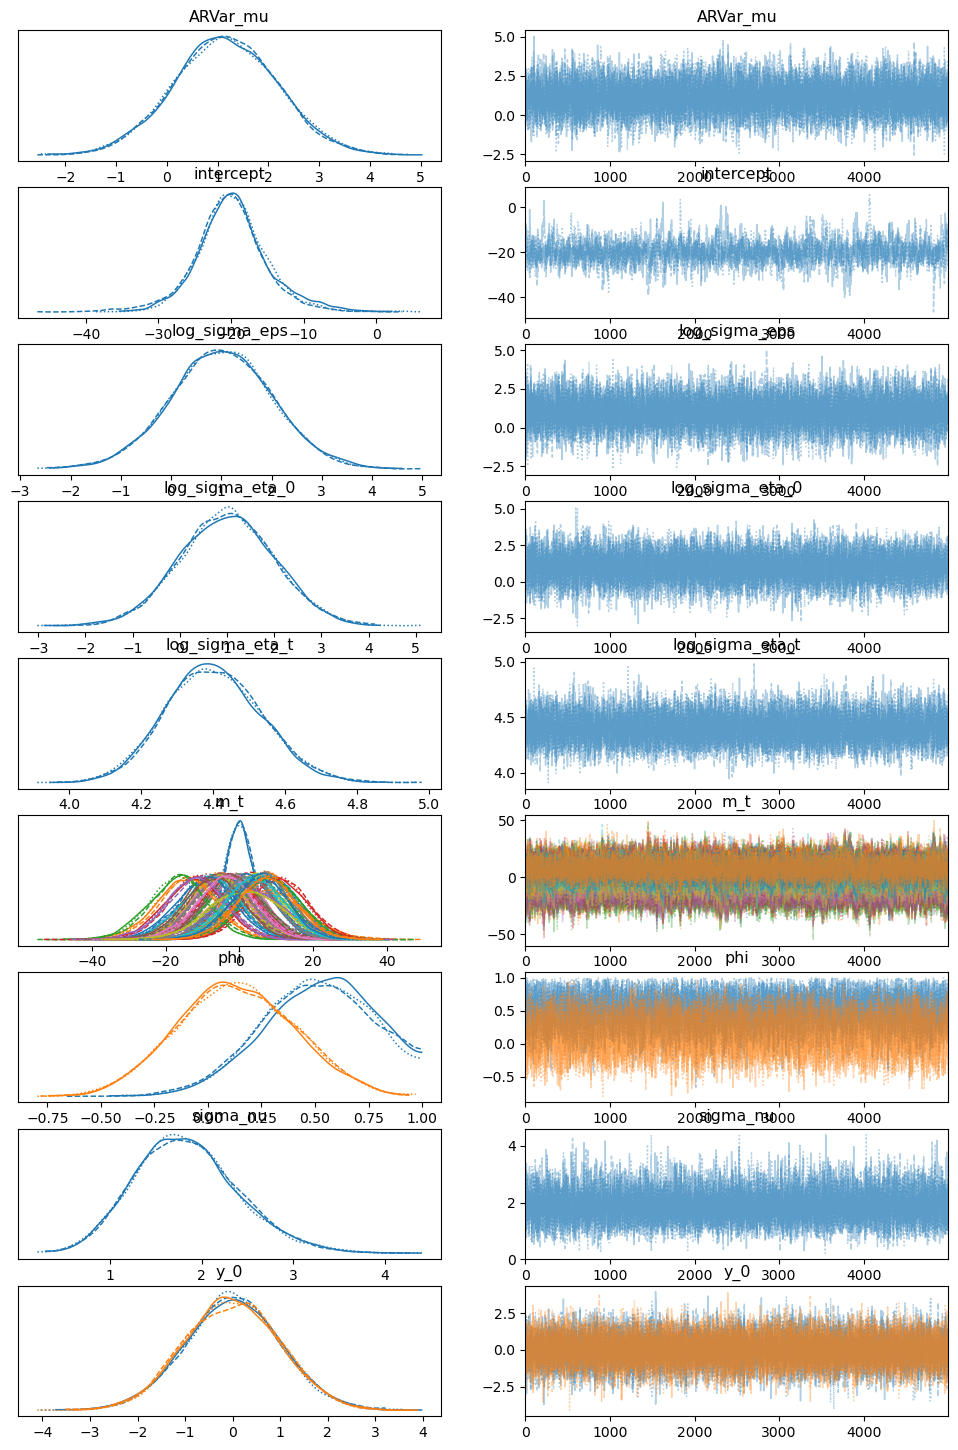

In [11]:
dfa_ftn('COVIDhub-4_week_ensemble', 'COVIDhub-baseline', 'diff', 'both', p=2, q=1, sigma_time = 'constant', ar_constraint = '[-1,1]')